<a href="https://colab.research.google.com/github/hamsterjoa/Kbank_playstore_review_analysis/blob/master/src/sentiment_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Contextualized Topic Models, CTM , BERTopic설치

In [ ]:
%%capture
!pip install contextualized-topic-models==2.2.0

In [ ]:
%%capture
!pip install pyldavis

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!pip install bertopic

In [ ]:
!pip install bertopic[visualization]

### Load Packages

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from collections import Counter
# wordcloud packages
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
%matplotlib inline
# combined topic modeling packages
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Mecab
from tqdm import tqdm
import nltk
# korean bertopic packages
from bertopic import BERTopic

In [ ]:
# 파일 불러오기
train = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/train_data_for_modeling.pkl")
test = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/test_data_for_modeling.pkl")

## **EDA**

In [ ]:
print(train.shape)
print(test.shape)

(1530, 5)
(510, 5)


In [ ]:
reviews = list(train['content'])

reviews_split_space = [r.split() for r in reviews] # 공백을 기준으로 문자열을 나누어 저장
review_len_space = [len(t) for t in reviews_split_space] # 나뉜 리스트에 대해 해당 리뷰들의 길이 저장

review_fulllen = [len(k.replace(' ', '')) for k in reviews] # 공백 제거 후 리뷰들의 길이 저장

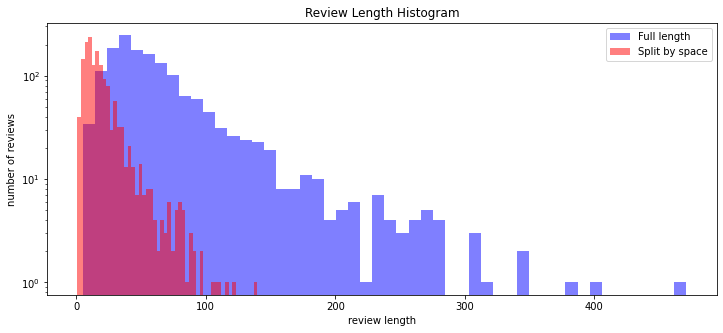

In [ ]:
# 데이터들의 길이의 빈도수를 Histogram으로 시각화
plt.figure(figsize=(12, 5))

plt.hist(review_fulllen,bins=50,alpha=0.5,color='b',label='Full length')
plt.hist(review_len_space,bins=50,alpha=0.5,color='r',label='Split by space')

plt.yscale('log', nonposy='clip')
plt.title('Review Length Histogram')
plt.xlabel('review length')
plt.ylabel('number of reviews')
plt.legend()

In [ ]:
print('--- Full Length Case ---')
print('문장 최대 길이 : {}'.format(np.max(review_fulllen)))
print('문장 최소 길이 : {}'.format(np.min(review_fulllen)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(review_fulllen)))
print('문장 길이 표준편타 : {:.2f}'.format(np.std(review_fulllen)))
print('문장 중간 길이 : {}'.format(np.median(review_fulllen)))
print('제 1사분위 길이 : {}'.format(np.percentile(review_fulllen, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(review_fulllen, 75)))

--- Full Length Case ---
문장 최대 길이 : 471
문장 최소 길이 : 5
문장 평균 길이 : 66.37
문장 길이 표준편타 : 51.40
문장 중간 길이 : 52.0
제 1사분위 길이 : 35.0
제 3사분위 길이 : 79.0


In [ ]:
print('--- Split by Space Length Case ---')
print('문장 최대 길이 : {}'.format(np.max(review_len_space)))
print('문장 최소 길이 : {}'.format(np.min(review_len_space)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(review_len_space)))
print('문장 길이 표준편타 : {:.2f}'.format(np.std(review_len_space)))
print('문장 중간 길이 : {}'.format(np.median(review_len_space)))
print('제 1사분위 길이 : {}'.format(np.percentile(review_len_space, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(review_len_space, 75)))

--- Split by Space Length Case ---
문장 최대 길이 : 140
문장 최소 길이 : 1
문장 평균 길이 : 19.08
문장 길이 표준편타 : 16.08
문장 중간 길이 : 15.0
제 1사분위 길이 : 9.0
제 3사분위 길이 : 23.0


## **긍정/부정 단어 Top 10**

In [ ]:
positive_words = np.hstack(train[train.label == 1]['tokenized'].values)
negative_words = np.hstack(train[train.label == 0]['tokenized'].values)

In [ ]:
positive_word_count = Counter(positive_words)
print('긍정 top10: ',positive_word_count.most_common(10))

긍정 top10:  [('사용', 54), ('좋아요', 32), ('너무', 30), ('계좌', 26), ('알림', 21), ('이용', 21), ('수수료', 19), ('이체', 19), ('카드', 19), ('업데이트', 18)]


😃 *전체적으로 고객이 메인 서비스에 대해서 사용하기 좋다고 느끼고 있으며 주기능(계좌이체 및 카드연동, 수수료 측면)에서 만족감을 느끼고 있음을 알 수 있습니다. 그리고 '업데이트'라는 단어로 미루어 짐작컨데, 앱의 업데이트 전보다 후에 사용감이 좋다는 추측이 가능합니다.*

In [ ]:
negative_word_count = Counter(negative_words)
print('부정 top10: ',negative_word_count.most_common(10))

부정 top10:  [('인증', 323), ('다시', 273), ('계좌', 272), ('계속', 227), ('사용', 220), ('화면', 217), ('신분증', 217), ('인식', 182), ('설치', 175), ('가입', 171)]


😭 *가입절차에서의 오류, 튕김 등의 에러가 발생하고 있다고 추측할 수 있습니다. 앱 접속시, 인증 절차의 오류 등 부기능적인 측면에서의 불편함을 호소하고 있음으로 해당 부분 개선이 필요합니다.*

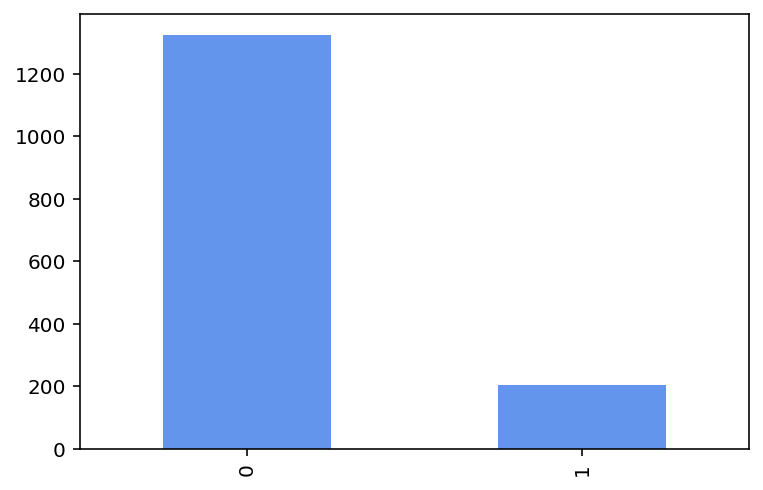

In [ ]:
train['label'].value_counts().plot(kind='bar',color='cornflowerblue')

🤑 *케이뱅크 앱의 경우, 앞선 RNN을 사용한 모델링 기법에서도 보여드렸듯이 전체 리뷰 중에 부정리뷰가 약 87%를 차지하고 있습니다. 따라서 긍정리뷰보다 부정리뷰의 개선에 초점을 맞춰 고객 만족도를 높일 수 있도록 해야 합니다.*

## **워드 클라우드**

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

In [ ]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


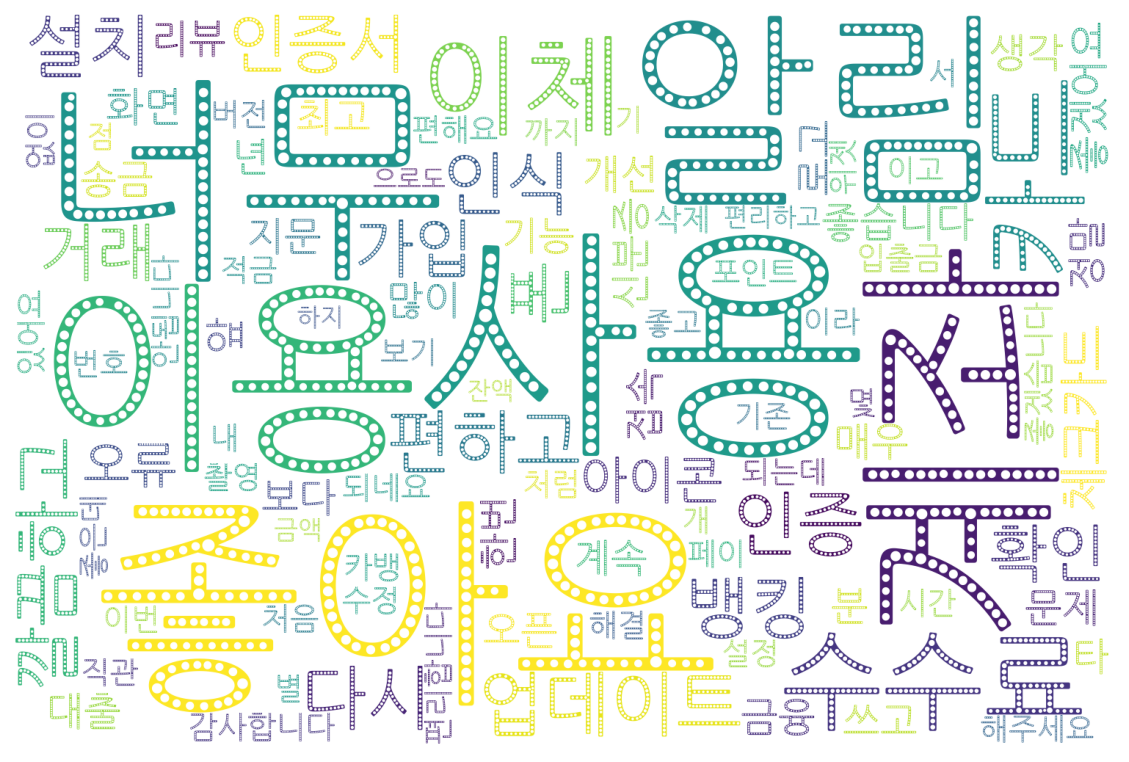

In [ ]:
# 긍정 워드 클라우드
%config InlineBackend.figure_format = 'retina'

data = positive_word_count.most_common(100)

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
wc = WordCloud(font_path= path, relative_scaling=0.2, background_color='white',
               width=1500, height=1000).generate_from_frequencies(dict(data))

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

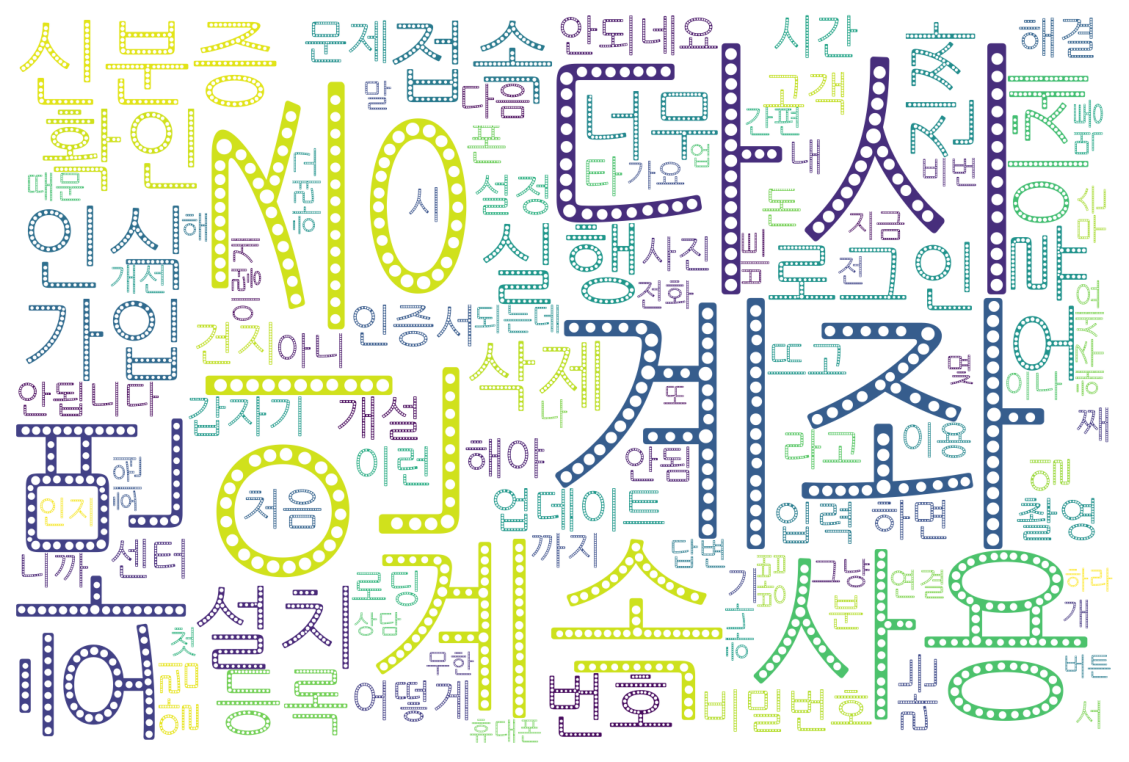

In [ ]:
# 부정 워드 클라우드
%config InlineBackend.figure_format = 'retina'

data = negative_word_count.most_common(100)

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
wc = WordCloud(font_path= path, relative_scaling=0.2, background_color='white',
               width=1500, height=1000).generate_from_frequencies(dict(data))

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## **복합 토픽 모델링(Combined Topic Modeling)**

In [ ]:
# train, test 데이터 합치기
all_data = pd.concat([train, test]).reset_index(drop=True)
print(all_data.shape)

(2040, 5)


In [ ]:
df = all_data['content']
# 토픽 모델링을 위한 txt 파일로 저장
text_file = df.to_csv('content.txt', sep='\t', index=False)

### 전처리

In [ ]:
documents = [line.strip() for line in open('/content/content.txt', encoding='utf-8').readlines()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/content/content.txt' mode='r' encoding='utf-8'>



Issue@2022-08-26 : 본래 불용어 제거가 완료된 컬럼인 tokenized컬럼을 사용하여 복합 토픽 모델을 학습시켜 보았지만, 시각화 결과가 좋지 않아, 부득이하게 따로 불용어 제거가 되지 않은 content컬럼을 사용하게 되었습니다. 이점은 추후에 다시 고쳐보도록 하겠습니다.

In [ ]:
preprocessed_documents = []

for line in tqdm(documents):
  # 빈 문자열이거나 숫자로만 이루어진 줄은 제외
  if line and not line.replace(' ', '').isdecimal():
    preprocessed_documents.append(line)

100%|██████████| 2041/2041 [00:00<00:00, 594236.74it/s]


In [ ]:
preprocessed_documents[:5]

['content',
 '아으   업데이트 했더니 바이오인증 바뀌었다며 본인 인증 다시해야함 내 명의 폰도 카드도 없는데 조깥네',
 '이거 서버문제지 아이폰인데 그냥튕기는데 어디서 설정어쩌구저쩌구야 개소리말고 복구하세요',
 '원래 페이지 이동시나 로딩시 케이뱅크의  로고가 화면 중앙에서 로딩중이라는걸 알려줬는데 언제부터인가 사라졌네요 굉장히 답답합니다 터치시 딜레이가 없을 정도로 빠른 앱도 아닌데 로딩마크가 사라지니 이건 내가 터치미스인지 아닌지를 기다려야 확인이 가능하니 엄청 답답해요 한국 사람 성질 알면서 로딩마크를 왜지웠나 궁금하네요 로딩마크 돌려주세요 개발자분이 뭔가 잘 못 생각하신거 같은데 로딩마크는 로딩중입니다를 알려주는게 아니라 당신의 터치는 입력되었으니 잠시만 기다려주세요를 알려주는거니까',
 '아니 잘쓰다가 앱이 실행 화면에서 멈춰서 넘어갈 생각을 안합니다 여러번 삭제하고 다시 어플 깔아도 작동할 생각을 안합니다 제발 좀 사용 할 수 있게 만들어 주실 수 없을까요']

In [ ]:
len(preprocessed_documents)

2041

In [ ]:
class CustomTokenizer:
  def __init__(self, tagger):
    self.tagger = tagger
  def __call__(self, sent):
    word_tokens = self.tagger.morphs(sent)
    result = [word for word in word_tokens if len(word) > 1]
    return result

In [ ]:
custom_tokenizer = CustomTokenizer(Mecab())

In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [ ]:
train_bow_embeddings = vectorizer.fit_transform(preprocessed_documents)

In [ ]:
print(train_bow_embeddings.shape)

(2041, 3000)


In [ ]:
vocab = vectorizer.get_feature_names()
id2token = {k: v for k, v in zip(range(0, len(vocab)), vocab)}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
len(vocab)

3000

In [ ]:
train_contextualized_embeddings = bert_embeddings_from_list(preprocessed_documents, \
                                                            "sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
qt = TopicModelDataPreparation()

training_dataset = qt.load(train_contextualized_embeddings, train_bow_embeddings, id2token)

### Combined TM 학습하기

토픽 모델을 학습합니다. 여기서는 하이퍼파라미터에 해당하는 토픽의 개수(n_components)fhsms 50개를 선정합니다.

In [ ]:
ctm = CombinedTM(bow_size=len(vocab), contextual_size=768, n_components=50, num_epochs=20)
ctm.fit(training_dataset)

Epoch: [20/20]	 Seen Samples: [40820/40820]	Train Loss: 171.10746972225624	Time: 0:00:00.621308: : 20it [00:12,  1.59it/s]


In [ ]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['으로', '습니다', '뱅크', '에서', '케이'],
             1: ['지웠', '아도', '다가', '해야', '접속'],
             2: ['터리', '해놨', '거래', '대로', '가리'],
             3: ['해킹', '위험', '어도', '자꾸', '접속'],
             4: ['찮고', '노출', '꺼져', '건가요', '돌려'],
             5: ['죄송', '질타', '초보', '형광', '해봤으나'],
             6: ['죄송', '육안', '행중', '반려', '자명'],
             7: ['힘냅시다', '터진', '아도', '동안', '지웠'],
             8: ['정말로', '죄송', '행중', '돼야', '육안'],
             9: ['넘어가', '화면', '이거', '대대', '저번'],
             10: ['네트', '은행장', '느리', '발생', '안드로이드'],
             11: ['케이', '합니다', '인증', '습니다', '고객'],
             12: ['확인', '어요', '은데', '이렇게', '으면'],
             13: ['으로', '해서', '에서', '번호', '등록'],
             14: ['다운', '반사', '전체', '들어왔', '아야'],
             15: ['네요', '확인', '다른', '인데', '케이'],
             16: ['아니', '네요', '는데', '사용', '다른'],
             17: ['어서', '네요', '하나', '라는', '건지'],
             18: ['업데이트', '이런', '접속', '나오', '계속'],
             19: ['거지', '백그라운드', '파이', '신경'

### 시각화

In [ ]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.save_html(ctm_pd, '/content/drive/MyDrive/Colab Notebooks/vis_html')
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:06,  1.59it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/vis_html' mode='w' encoding='UTF-8'>



## **한국어 버토픽(Korean BERTopic)**

BERTopic에서도 복합 토픽 모델링에서 전처리한 preprocessed_documents를 사용하도록 하겠습니다.

### Mecab과 SBERT를 이용한 Bertopic

In [ ]:
class CustomTokenizer:
  def __init__(self, tagger):
    self.tagger = tagger
  def __call__(self, sent):
    sent = sent[:1000000]
    word_tokens = self.tagger.morphs(sent)
    result = [word for word in word_tokens if len(word) > 1]
    return result

In [ ]:
custom_tokenizer = CustomTokenizer(Mecab())

In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [ ]:
model = BERTopic(embedding_model="sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens", \
                 vectorizer_model=vectorizer,
                 nr_topics=50,
                 top_n_words=10,
                 calculate_probabilities=True)

In [ ]:
topics, probs = model.fit_transform(preprocessed_documents)

print('각 문서의 토픽 번호 리스트 :',len(topics))
print('첫번째 문서의 토픽 번호 :', topics[0])

각 문서의 토픽 번호 리스트 : 2041
첫번째 문서의 토픽 번호 : 7


In [ ]:
# get_topic_info() 메소드를 사용하여 토픽의 개수, 토픽의 크기, 각 토픽에 할당된 단어들을 일부 볼 수 있습니다.
model.get_topic_info()

,Topic,Count,Name
0,-1,1198,-1_는데_네요_뱅크_인증
1,0,11,0_립니_사용_아쉽_그라운드
2,1,58,1_실행_네요_어제_해도
3,2,14,2_업그레이드_건지_원격_로그인
4,3,13,3_예약_보내_지문_검증
5,4,21,4_채널_접근_만들_번호
6,5,17,5_최고_편리_편하_아요
7,6,17,6_아요_최고_아주_최대한도
8,7,25,7_편리_편해요_깔끔_사용
9,8,10,8_인증_촬영_사진_본인


위의 출력에서 Topic -1이 가장 큰 것으로 보입니다. -1은 토픽이 할당되지 않은 모든 이상치 문서들을(outliers)들을 나타냅니다.

### 시각화

In [ ]:
# 단어 시각화
model.visualize_barchart() 

In [ ]:
# 토픽 유사도 시각화
model.visualize_heatmap()

/usr/local/lib/python3.7/dist-packages/plotly/express/_imshow.py:354: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
# 토픽 시각화
model.visualize_topics()

In [ ]:
model.visualize_distribution(probs[0])